# Navigation MDP [1]

In [1]:
# Other Imports.
from simple_rl.tasks import NavigationMDP
from simple_rl.agents import QLearningAgent
from simple_rl.planning import ValueIteration
from simple_rl.tasks.grid_world.GridWorldStateClass import GridWorldState

# Python Imports.
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

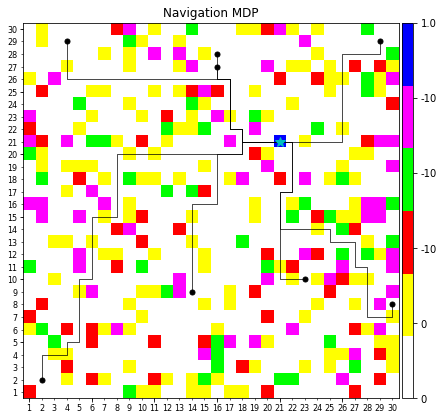

In [2]:
np.random.seed(0)
nvmdp = NavigationMDP(width=30, height=30, 
                      living_cell_types=['white', 'yellow', 'red', 'lime', 'magenta'],
                      living_cell_rewards=[0, 0, -10, -10, -10],
                      living_cell_distribution="probability",
                      living_cell_type_probs=[0.68, 0.17, 0.05, 0.05, 0.05],
                      goal_cell_locs=[(21,21)],
                      goal_cell_rewards=[1.],
                      goal_cell_types=["blue"],
                      slip_prob=0.00, step_cost=0.0, gamma=.99)
# Use "init_states" to request specific init states while sampling trajectories
# if "n_trajectory" is greater than # of init_states, remaining init states will be sampled randomly
state_trajectories, action_trajectories = nvmdp.sample_data(n_trajectory=8, 
                                                            init_states=[GridWorldState(2,2)], 
                                                            init_repetition=False)
nvmdp.visualize_grid(trajectories=state_trajectories, show_colorbar=True, show_rewards_colorbar=True, goal_marker="*c")

## Features used for short horizon

In [3]:
print("Sample State Trajectory \nFeatures: Cell Indicator {} + Distsances to {} + Distance to {}\n".format(nvmdp.cell_types, nvmdp.cell_types, nvmdp.goal_cell_types))
[nvmdp.feature_at_state(s,
                        feature_type="indicator",
                        incl_cell_distances=True,
                        incl_goal_indicator=False,
                        incl_goal_distances=True,
                        normalize_distance=False, dtype=np.float).tolist() for s in state_trajectories[0]]

Sample State Trajectory 
Features: Cell Indicator ['white', 'yellow', 'red', 'lime', 'magenta', 'blue'] + Distsances to ['white', 'yellow', 'red', 'lime', 'magenta', 'blue'] + Distance to ['blue']



[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 4.0, 10.0, 38.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 9.0, 37.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, 2.0, 8.0, 36.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 7.0, 35.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 2.0, 6.0, 34.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 5.0, 33.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 4.0, 32.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 3.0, 3.0, 31.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 4.0, 3.0, 30.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, 5.0, 2.0, 29.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 4.0, 6.0, 1.0, 28.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 4.0, 5.0, 1.0, 27.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 5.0, 1.0, 26.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 4.0, 1.0, 25.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, 5.0, 1.0, 24.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 3.0, 6.0, 2.0, 23.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 7.0, 2.0, 22.

## Features used for long horizon

In [4]:
print("Sample State Trajectory \nFeatures: Cell Indicator {} + Distance to {}\n".format(nvmdp.cell_types, nvmdp.goal_cell_types))
[nvmdp.feature_at_state(s,
                        feature_type="indicator",
                        incl_cell_distances=False,
                        incl_goal_indicator=False,
                        incl_goal_distances=True,
                        normalize_distance=False, dtype=np.float).tolist() for s in state_trajectories[0]]

Sample State Trajectory 
Features: Cell Indicator ['white', 'yellow', 'red', 'lime', 'magenta', 'blue'] + Distance to ['blue']



[[1.0, 0.0, 0.0, 0.0, 0.0, 38.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 37.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 36.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 35.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 34.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 33.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 32.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 31.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 30.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 29.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 28.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 27.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 26.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 25.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 24.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 23.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 22.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 21.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 20.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 19.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 18.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 17.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 16.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 15.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 14.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 13.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 12.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 11.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 10.0],
 [1.0, 0.0, 0.

## Multiple Goals

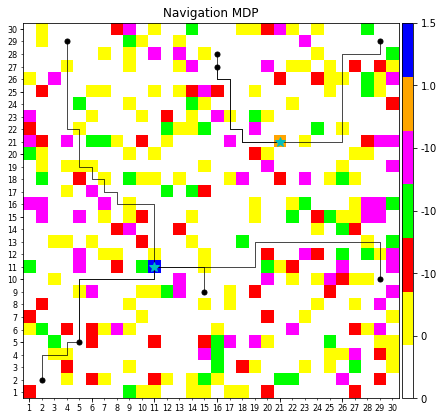

Sample State Trajectory


[[1.0, 0.0, 0.0, 0.0, 0.0, 38.0, 18.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 37.0, 17.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 36.0, 16.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 35.0, 15.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 34.0, 14.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 33.0, 13.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 32.0, 12.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 31.0, 11.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 30.0, 10.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 29.0, 9.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 28.0, 8.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 27.0, 7.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 26.0, 6.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 25.0, 5.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 24.0, 4.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 23.0, 3.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 22.0, 2.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 21.0, 1.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0]]

In [5]:
np.random.seed(0)
nvmdp = NavigationMDP(width=30, height=30, 
                      living_cell_types=['white', 'yellow', 'red', 'lime', 'magenta'],
                      living_cell_rewards=[0, 0, -10, -10, -10],
                      living_cell_distribution="probability",
                      living_cell_type_probs=[0.68, 0.17, 0.05, 0.05, 0.05],
                      goal_cell_locs=[(21,21), (11,11)],
                      goal_cell_rewards=[1., 1.5],
                      goal_cell_types=["orange","blue"],
                      slip_prob=0.00, step_cost=0.0, gamma=.95)
state_trajectories, action_trajectories = nvmdp.sample_data(n_trajectory=8, 
                                                            init_states=[GridWorldState(2,2)], 
                                                            init_repetition=False)
nvmdp.visualize_grid(trajectories=state_trajectories, show_colorbar=True, show_rewards_colorbar=True, goal_marker="*c")
## Features: Cell Type Ind + Cell Type Dist + Goal Dist
print("Sample State Trajectory")
[nvmdp.feature_at_state(s,
                        feature_type="indicator",
                        incl_cell_distances=False,
                        incl_goal_indicator=False,
                        incl_goal_distances=True,
                        normalize_distance=False, dtype=np.float).tolist() for s in state_trajectories[0]]

## Custom Grid

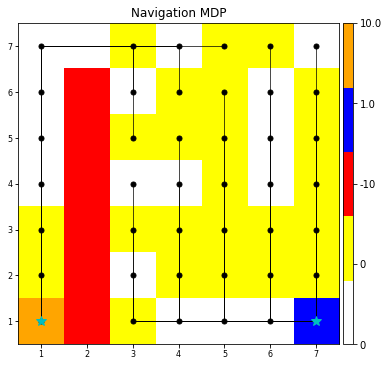

In [6]:
nvmdp = NavigationMDP(width=7, height=7,
                      living_cell_types=['white', 'yellow', 'red'],
                      living_cell_rewards=[0, 0, -10],
                      living_cell_distribution="manual",
                      living_cell_locs=[np.inf, np.inf, [(2,i) for i in range(1,7)]],
                      goal_cell_locs=[(7,1),(1,1)],
                      goal_cell_types=["blue", "orange"],
                      goal_cell_rewards=[1.,10.],
                      traj_init_cell_types=[0,1],
                      slip_prob=0.00, step_cost=0.0, gamma=.50)
state_trajectories, action_trajectories = nvmdp.sample_data(n_trajectory=41, init_states=[GridWorldState(1,1)], init_repetition=False)
nvmdp.visualize_grid(trajectories=state_trajectories, show_colorbar=True, show_rewards_colorbar=True, goal_marker="*c")

## Updating Goals dynamically

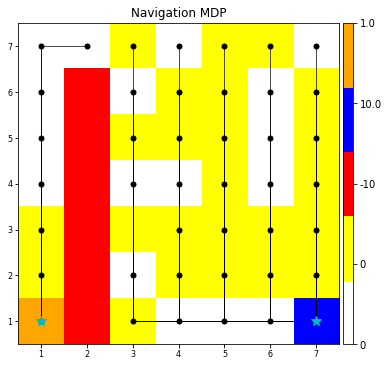

In [7]:
nvmdp._reset_goals([(7,1),(1,1)],[10.,1.],["blue", "orange"])
state_trajectories, action_trajectories = nvmdp.sample_data(n_trajectory=41, init_states=[GridWorldState(1,1)], init_repetition=False)
nvmdp.visualize_grid(trajectories=state_trajectories, show_colorbar=True, show_rewards_colorbar=True, goal_marker="*c")

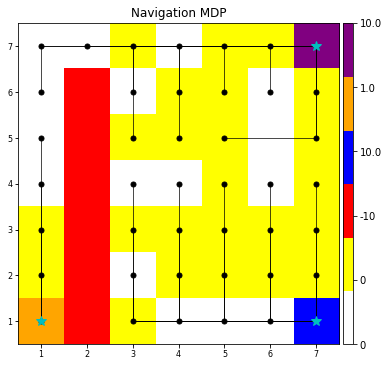

In [8]:
nvmdp._reset_goals([(7,1),(1,1),(7,7)],[10.,1.,10.],["blue", "orange","purple"])
state_trajectories, action_trajectories = nvmdp.sample_data(n_trajectory=41, init_states=[GridWorldState(1,1)], init_repetition=False)
nvmdp.visualize_grid(trajectories=state_trajectories, show_colorbar=True, show_rewards_colorbar=True, goal_marker="*c")

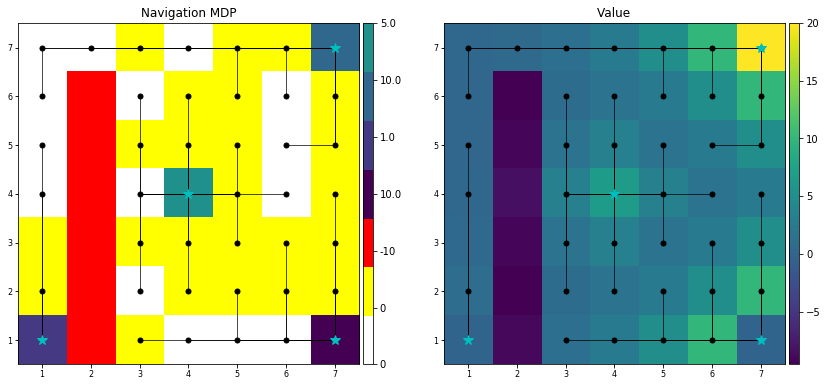

In [9]:
nvmdp._reset_goals([(7,1),(1,1),(7,7),(4,4)],[10.,1.,10.,5.],list(range(4))) 
state_trajectories, action_trajectories = nvmdp.sample_data(n_trajectory=41, init_states=[GridWorldState(1,1)], init_repetition=False)
plt.figure(figsize=(14,8))
nvmdp.visualize_grid(trajectories=state_trajectories, show_colorbar=True, show_rewards_colorbar=True, goal_marker="*c", new_fig=False, subplot_str="121")
nvmdp.visualize_grid(nvmdp.get_value_grid(), trajectories=state_trajectories, show_colorbar=True, show_rewards_colorbar=False, goal_marker="*c", new_fig=False, subplot_str="122", 
                     state_space_cmap=False, title="Value")

## Updating Rewards dynamically

In [10]:
nvmdp.living_cell_rewards, nvmdp.goal_cell_rewards

([0, 0, -10], [10.0, 1.0, 10.0, 5.0])

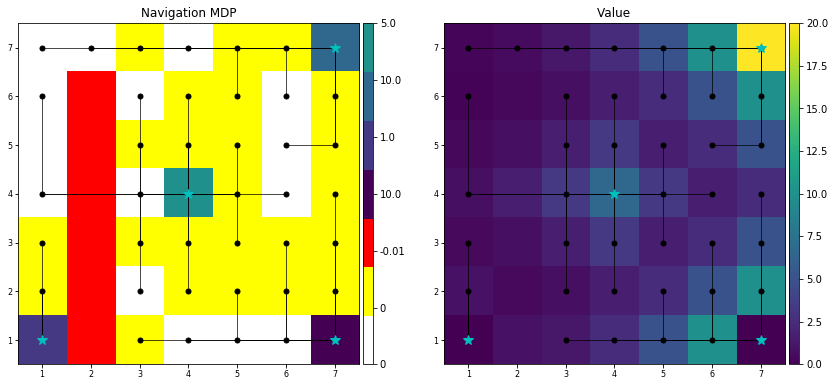

In [11]:
nvmdp._reset_rewards([0, 0, -0.01], [10.0, 1.0, 10.0, 5.0])
state_trajectories, action_trajectories = nvmdp.sample_data(n_trajectory=41, init_states=[GridWorldState(1,1)], init_repetition=False)
plt.figure(figsize=(14,8))
nvmdp.visualize_grid(trajectories=state_trajectories, show_colorbar=True, show_rewards_colorbar=True, goal_marker="*c", new_fig=False, subplot_str="121")
nvmdp.visualize_grid(nvmdp.get_value_grid(), trajectories=state_trajectories, show_colorbar=True, show_rewards_colorbar=False, goal_marker="*c", new_fig=False, subplot_str="122", 
                     state_space_cmap=False, title="Value")

## Reference

[1] MacGlashan, James, and Michael L. Littman. "Between Imitation and Intention Learning." IJCAI. 2015.